<a href="https://colab.research.google.com/github/kovzanok/ml2/blob/main/hw_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from typing import List, Dict
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet


from collections import Counter
from typing import List
import string
import re

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

Изначальный метод скачивания датасета не работал, поэтому пришлось напрямую через pandas

In [4]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv", header=None)
df.columns = ['label', 'title', 'description']


In [5]:
df['label'] = df['label'] - 1

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
def process_text(text:str)->str:
    return text.lower().translate(
        str.maketrans('', '', string.punctuation))

In [7]:
words = Counter()

for example in tqdm(df['description']):
    # Приводим к нижнему регистру и убираем пунктуацию
    processed_text = process_text(example)
    for word in word_tokenize(processed_text):
        words[word] += 1

print(words)

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Counter({'the': 197156, 'a': 102702, 'to': 95227, 'of': 88851, 'in': 77872, 'and': 65827, 'on': 47015, 'for': 37775, 'that': 27373, '39s': 25059, 'with': 22571, 'as': 21740, 'its': 21715, 'at': 20674, 'is': 19876, 'said': 19826, 'by': 18572, 'it': 18248, 'has': 18215, 'new': 17213, 'an': 16401, 'from': 15677, 'his': 14366, 'us': 13526, 'will': 13412, 'was': 13348, 'reuters': 12981, 'after': 12382, 'have': 10617, 'be': 10295, 'their': 10182, 'are': 9065, 'over': 8801, 'ap': 8370, 'he': 8320, 'but': 8238, 'two': 8044, 'first': 7912, 'this': 7685, 'more': 7542, 'monday': 7339, 'wednesday': 7249, 'tuesday': 7190, 'thursday': 7071, 'company': 6750, 'up': 6606, 'friday': 6586, 'inc': 6481, 'one': 6433, 'world': 6263, 'yesterday': 6020, 'they': 5990, 'last': 5973, 'york': 5931, 'not': 5901, 'against': 5885, 'than': 5830, 'about': 5828, 'who': 5779, 'were': 5727, 'into': 5655, 'year': 5505, 'been': 5428, 'president': 5342, 'out': 5340, 'had': 5138, 'when': 4850, 'million': 4802, 'oil': 4721, '

In [8]:
class WordDataset:
    def __init__(self, df):
        self.df = df
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = process_text(self.df[idx:idx+1]['description'].item())
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label":self.df[idx:idx+1]['label'].item()
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.df)


def collate_fn_with_padding(
    input_batch: List[dict({"text": str, "label": str})], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [9]:
train_df, test_df = train_test_split(df, random_state=42, test_size=5000, train_size=50000)

train_dataset = WordDataset(train_df[['label','description']])
eval_dataset = WordDataset(test_df[['label','description']])

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [10]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Вот несколько идей экспериментов:
* **Модель RNN**. Мы пока не проходили, как устроены другие нейросетевые модели --- LSTM и GRU. Тем не менее, никто не запрещает использовать их в этом эксперименте. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

###Функции для обучение

In [11]:
def train_epoch(model, criterion, dataloader, optimizer):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(dataloader):
        x, y = batch['input_ids'], batch['label']
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_samples += y.shape[0]

    accuracy = total_correct/total_samples

    avg_loss = total_loss/len(dataloader)

    return avg_loss, accuracy

В функции обучения аргумент patience отвечает за кол-во эпох без улучшения test_acc, после которых обучение заканчивается

In [12]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs = 5, scheduler = None, patience = 3):
    best_acc = 0
    epochs_no_improve = 0
    loss_history = []
    acc_history = {
        'train':[],
        'test':[]
    }


    for i in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(model, criterion, train_loader, optimizer)
        test_acc = evaluate(model, val_loader)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history.append(train_loss)

        print(f'Epoch {i+1}: train loss - {train_loss}, train accuracy - {train_acc}, test accuracy - {test_acc}')

        if scheduler:
            scheduler.step(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'/content/{model.__class__.__name__}.pth')
            print("✅ Model saved (best so far)")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    return loss_history, acc_history

###Визуализация

In [15]:
def plot_multiple_histories(histories: dict):
    """
    Строит графики loss и accuracy для нескольких моделей.

    histories: dict
        {
            'ModelA': {'loss': [...], 'train': [...], 'test': [...]},
            'ModelB': {'loss': [...], 'train': [...], 'test': [...]},
            ...
        }
    """
    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,2,1)
    for model_name, hist in histories.items():
        plt.plot(range(1, len(hist['loss'])+1), hist['loss'], marker='o', label=model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    for model_name, hist in histories.items():
        plt.plot(range(1, len(hist['train'])+1), hist['train'], marker='o', label=f"{model_name} Train")
        plt.plot(range(1, len(hist['test'])+1), hist['test'], marker='x', label=f"{model_name} Test")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Test Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


###Обычная RNN

In [13]:
class SimpleRNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 hidden_dim = 256,
                 dropout_rate = 0.1,
                 rnn_layers = 1,
                 n_classes = 4,
                 aggregation_type = 'last',
                ) -> None:
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Embedding(vocab_size, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=rnn_layers, batch_first=True)
        self.nonlinear = nn.Tanh()

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout_rate),          # для регуляризации
            nn.Tanh(),
            nn.Linear(hidden_dim, n_classes) # финальный слой
        )

        self.aggregation_type = aggregation_type

    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        if self.aggregation_type == 'last':
            output = output[:,-1,:]
        elif self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation type')

        return self.classifier(self.nonlinear(output))

###Сравним aggregation type

In [14]:
model = SimpleRNN(vocab_size=len(vocab))
model = model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())
history = train(model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss - 1.3978717439996837, train accuracy - 0.2552, test accuracy - 0.2401999980211258
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss - 1.3965885138862497, train accuracy - 0.25438, test accuracy - 0.25279998779296875
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss - 1.3966184878913699, train accuracy - 0.25138, test accuracy - 0.25200000405311584


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss - 1.3960995452951637, train accuracy - 0.25364, test accuracy - 0.25040000677108765


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss - 1.3952844678325982, train accuracy - 0.25244, test accuracy - 0.2533999979496002
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss - 1.395873893550475, train accuracy - 0.2592, test accuracy - 0.25679999589920044
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss - 1.395118926857346, train accuracy - 0.25664, test accuracy - 0.25519999861717224


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss - 1.3935937961552742, train accuracy - 0.262, test accuracy - 0.25040000677108765


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss - 1.3930733540236606, train accuracy - 0.26042, test accuracy - 0.280599981546402
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss - 1.3917535654795299, train accuracy - 0.26172, test accuracy - 0.2613999843597412


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss - 1.3880229960323829, train accuracy - 0.26642, test accuracy - 0.24319998919963837


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss - 1.3953132327367157, train accuracy - 0.25778, test accuracy - 0.24959999322891235
Early stopping


In [17]:
mean_agg_model = SimpleRNN(vocab_size=len(vocab),aggregation_type='mean').to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(mean_agg_model.parameters())
mean_history = train(mean_agg_model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss - 0.6207273588900145, train accuracy - 0.76228, test accuracy - 0.8625999689102173
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss - 0.34494456827106645, train accuracy - 0.88124, test accuracy - 0.8775999546051025
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss - 0.2720641579672036, train accuracy - 0.90628, test accuracy - 0.8845999836921692
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss - 0.22063305975079192, train accuracy - 0.9254, test accuracy - 0.8837999701499939


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss - 0.18652005991240056, train accuracy - 0.93724, test accuracy - 0.894599974155426
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss - 0.15425819458329118, train accuracy - 0.9473, test accuracy - 0.8849999904632568


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss - 0.1326994993533255, train accuracy - 0.95424, test accuracy - 0.8841999769210815


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss - 0.11270853481195886, train accuracy - 0.96054, test accuracy - 0.8815999627113342
Early stopping


In [18]:
max_agg_model = SimpleRNN(vocab_size=len(vocab),aggregation_type='max').to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(max_agg_model.parameters())
max_history = train(max_agg_model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss - 0.5319966931880398, train accuracy - 0.79692, test accuracy - 0.8651999831199646
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss - 0.32857690983936333, train accuracy - 0.88484, test accuracy - 0.8769999742507935
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss - 0.2701232348207053, train accuracy - 0.90378, test accuracy - 0.8849999904632568
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss - 0.23117331493710258, train accuracy - 0.91858, test accuracy - 0.8799999952316284


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss - 0.19860406356112303, train accuracy - 0.93012, test accuracy - 0.8885999917984009
✅ Model saved (best so far)


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss - 0.17197349679347076, train accuracy - 0.93974, test accuracy - 0.8829999566078186


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss - 0.14739864773128328, train accuracy - 0.94734, test accuracy - 0.8833999633789062


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss - 0.12424194973506754, train accuracy - 0.95518, test accuracy - 0.8845999836921692
Early stopping


Лучший результат получился для aggregation type 'mean'

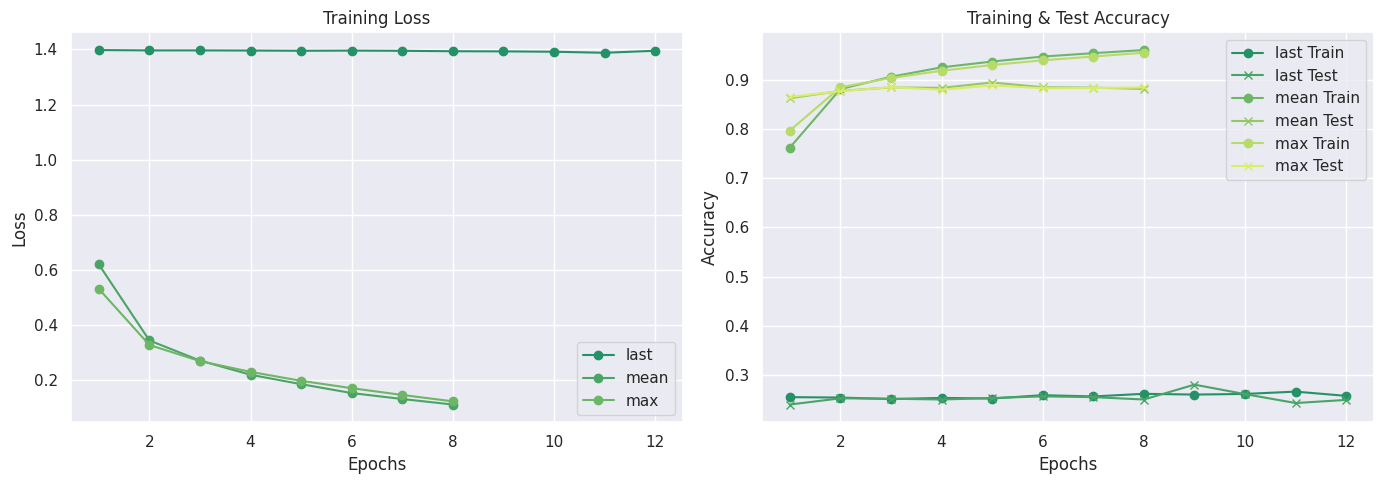

In [22]:
histories = {'last': {'loss': history[0], **history[1] },
             'mean': {'loss': mean_history[0], **mean_history[1] },
             'max': {'loss': max_history[0], **max_history[1] },
            }

plot_multiple_histories(histories)

###Добавим scheduler

In [ ]:
max_agg_model = SimpleRNN(vocab_size=len(vocab),aggregation_type='max')
criterion = CrossEntropyLoss()
optimizer = Adam(max_agg_model.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

history = train(max_agg_model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=15, scheduler=scheduler)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


###Добавим слои в RNN

In [ ]:
for i in range(2, 5):
    max_agg_model = SimpleRNN(vocab_size=len(vocab),aggregation_type='max', rnn_layers = i)
    criterion = CrossEntropyLoss()
    optimizer = Adam(max_agg_model.parameters())

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    history = train(max_agg_model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=15, scheduler=scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss - 0.8143325336110645, train accuracy - 0.67736, test accuracy - 0.77920001745224


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss - 0.5278840484294233, train accuracy - 0.8085, test accuracy - 0.8068000078201294


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss - 0.456965652848007, train accuracy - 0.83588, test accuracy - 0.8145999908447266


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss - 0.4155447128957575, train accuracy - 0.84976, test accuracy - 0.8230000138282776


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss - 0.3842825833004938, train accuracy - 0.86326, test accuracy - 0.8227999806404114


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss - 0.3572177489479421, train accuracy - 0.87144, test accuracy - 0.823199987411499


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss - 0.3363895204540292, train accuracy - 0.8799, test accuracy - 0.8205999732017517


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss - 0.31358006855166654, train accuracy - 0.88724, test accuracy - 0.8173999786376953


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss - 0.29410131284949187, train accuracy - 0.89602, test accuracy - 0.8113999962806702


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss - 0.27500355210076594, train accuracy - 0.90242, test accuracy - 0.8226000070571899


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss - 0.2652469601110339, train accuracy - 0.90488, test accuracy - 0.8155999779701233


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss - 0.24672405637076134, train accuracy - 0.91154, test accuracy - 0.8176000118255615


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss - 0.23529539420373705, train accuracy - 0.91568, test accuracy - 0.8090000152587891


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss - 0.22272517801913708, train accuracy - 0.92006, test accuracy - 0.8127999901771545


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: train loss - 0.2123313968666303, train accuracy - 0.92486, test accuracy - 0.8076000213623047


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss - 0.8568766067330073, train accuracy - 0.65868, test accuracy - 0.7748000025749207


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss - 0.5557781205401158, train accuracy - 0.8007, test accuracy - 0.8091999888420105


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss - 0.4833544487859375, train accuracy - 0.82828, test accuracy - 0.8123999834060669


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss - 0.436053805148571, train accuracy - 0.84632, test accuracy - 0.8095999956130981


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss - 0.405821479513755, train accuracy - 0.85578, test accuracy - 0.8248000144958496


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss - 0.3786425612752474, train accuracy - 0.86714, test accuracy - 0.8253999948501587


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss - 0.3613530766035377, train accuracy - 0.87304, test accuracy - 0.8235999941825867


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss - 0.33913153506963206, train accuracy - 0.88158, test accuracy - 0.8253999948501587


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss - 0.32281253205866134, train accuracy - 0.88584, test accuracy - 0.8194000124931335


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss - 0.3081873527067217, train accuracy - 0.8915, test accuracy - 0.8148000240325928


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss - 0.29582408114180914, train accuracy - 0.89772, test accuracy - 0.8208000063896179


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss - 0.28374578954410035, train accuracy - 0.90084, test accuracy - 0.8202000260353088


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss - 0.276703722231562, train accuracy - 0.90302, test accuracy - 0.823199987411499


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss - 0.26587857278236693, train accuracy - 0.90672, test accuracy - 0.8238000273704529


  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!wget https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip

--2025-08-24 11:13:51--  https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.2024.wikigiga.300d.zip [following]
--2025-08-24 11:13:52--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.2024.wikigiga.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1705239207 (1.6G) [application/zip]
Saving to: ‘glove.2024.wikigiga.300d.zip’

glove.2024.wikigiga 100%[===================>]   1.59G   518KB/s    in 27m 48s 

2025-08-24 11:41:41 (998 KB/s) - ‘glove.2024.wikigiga.300d.zip’ saved [1705239207/1705239207]



In [ ]:
!unzip glove.2024.wikigiga.300d.zip

Archive:  glove.2024.wikigiga.300d.zip
  inflating: wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt  


In [ ]:
embed_dim = 300

def load_glove(path, emb_size):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            if len(values) != emb_size + 1:
                continue
            word = values[0]

            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = "/content/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"
glove = load_glove(glove_path, embed_dim)
print("Векторов загружено:", len(glove))


Векторов загружено: 1287614


In [ ]:
vocab_size = len(word2ind)

embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embed_dim))  # init random
for word, idx in word2ind.items():
    vector = glove.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [ ]:
class GRUWithAttention(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_matrix,
                 input_size=256,   # размер эмбеддинга
                 hidden_dim = 256,
                 dropout_rate = 0.3,
                 gru_layers = 2,
                 n_classes = 4,
                ) -> None:
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=False,    # если True → эмбединги не будут обучаться
            padding_idx=word2ind['<pad>']
        )

        self.gru = nn.GRU(input_size, hidden_dim, batch_first=True, num_layers=gru_layers, bidirectional=True, dropout=0.3 if gru_layers > 1 else 0.0)
        self.nonlinear = nn.ReLU()
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Dropout(dropout_rate),          # для регуляризации
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes) # финальный слой
        )

    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.gru(embeddings)
        mask = (input_batch != word2ind['<pad>']).float()  # [B, T]
        attn_weights = self.attn(output).squeeze(-1)
        attn_weights = attn_weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(output * attn_weights.unsqueeze(-1), dim=1)


        return self.classifier(context)

In [ ]:
gru_with_attention_model = GRUWithAttention(vocab_size=len(vocab), embedding_matrix=embedding_matrix, hidden_dim=512, input_size=300)
gru_with_attention_model = gru_with_attention_model.to(device)
criterion = CrossEntropyLoss()
optimizer = AdamW([
  {'params': gru_with_attention_model.embedding.parameters(), 'lr': 1e-4},
  {'params': [p for n, p in gru_with_attention_model.named_parameters() if "embedding" not in n], 'lr': 3e-4}
], weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)



In [ ]:
history = train(gru_with_attention_model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=15, scheduler=scheduler, patience=3)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train loss - 0.5331219725329858, train accuracy - 0.80894, test accuracy - 0.8357999920845032
✅ Model saved (best so far)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train loss - 0.4175342231074258, train accuracy - 0.85082, test accuracy - 0.8405999541282654
✅ Model saved (best so far)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train loss - 0.37268043629577396, train accuracy - 0.86492, test accuracy - 0.8393999934196472


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: train loss - 0.333132042632917, train accuracy - 0.87744, test accuracy - 0.8348000049591064


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: train loss - 0.29641673924482387, train accuracy - 0.889, test accuracy - 0.8281999826431274
Early stopping


##Финальная версия

###Улучшенная предобработка датасета(удаляем стоп-слова, лемматизация)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# POS-теги для лемматизации
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default

def process_text(text: str) -> list[str]:
    # lowercase
    text = text.lower()

    # url → <URL>
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)
    # user → <USER>
    text = re.sub(r'@\w+', '<USER>', text)
    # hashtag → <HASHTAG>
    text = re.sub(r'#\w+', '<HASHTAG>', text)
    # проценты → <PERCENT>
    text = re.sub(r'(\d+)%', '<PERCENT>', text)
    # валюты → <MONEY>
    text = re.sub(r'\$\d+(\.\d+)?', '<MONEY>', text)
    # числа → <NUM>
    text = re.sub(r'\d+', '<NUM>', text)

    # сохраняем только полезные знаки: ! ? %
    keep_punct = '!?.'
    text = ''.join([c for c in text if c.isalnum() or c.isspace() or c in keep_punct])

    # токенизация
    tokens = word_tokenize(text)

    # удаляем стоп-слова, кроме отрицаний
    stop_words_filtered = stop_words - {'not', 'no', 'never'}
    tokens = [w for w in tokens if w not in stop_words_filtered]

    # POS-тегинг
    pos_tags = nltk.pos_tag(tokens)

    # лемматизация с учётом POS
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    # отбрасываем слишком длинные токены
    tokens = [t for t in tokens if len(t) <= 20]

    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
words = Counter()

for example in tqdm(df['description']):
    tokens = process_text(example)
    for word in tokens:
        words[word] += 1

print(words)

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Counter({'.': 133396, 'NUM': 38902, 'say': 25682, 'HASHTAGs': 25148, 'new': 17341, 'reuters': 12981, 'NUMNUM': 11896, 'year': 10029, 'company': 9373, 'ap': 8369, 'u': 8338, 'two': 8045, 'first': 7917, 'monday': 7375, 'wednesday': 7283, 'tuesday': 7225, 'world': 7100, 'thursday': 7100, 'MONEY': 6645, 'friday': 6637, 'one': 6577, 'week': 6200, 'yesterday': 6094, 'state': 6046, 'report': 6033, 'last': 6026, 'york': 5983, 'game': 5977, 'not': 5902, 'make': 5673, 'inc.': 5626, 'president': 5436, 'million': 5300, 'take': 5250, 'u.s.': 5057, 'price': 4932, 'time': 4882, '...': 4799, 'sunday': 4740, 'oil': 4738, 'plan': 4731, 'day': 4707, 'would': 4583, 'government': 4574, 'group': 4550, 'official': 4538, 'people': 4472, 'today': 4462, 'three': 4373, 'service': 4358, 'lead': 4254, 'security': 4185, 'team': 4172, 'could': 4161, 'quot': 4063, 'month': 4032, 'corp.': 3990, 'no': 3980, 'announce': 3971, 'win': 3965, 'saturday': 3939, 'night': 3906, 'kill': 3889, 'percent': 3875, 'software': 3822, 

###Загрузка предобученных эмбедингов

In [ ]:
!wget https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip

--2025-08-25 07:19:17--  https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.2024.wikigiga.300d.zip [following]
--2025-08-25 07:19:17--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.2024.wikigiga.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1705239207 (1.6G) [application/zip]
Saving to: ‘glove.2024.wikigiga.300d.zip’

glove.2024.wikigiga 100%[===================>]   1.59G  5.13MB/s    in 5m 29s  

2025-08-25 07:24:46 (4.95 MB/s) - ‘glove.2024.wikigiga.300d.zip’ saved [1705239207/1705239207]


In [ ]:
!unzip glove.2024.wikigiga.300d.zip

Archive:  glove.2024.wikigiga.300d.zip
  inflating: wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt  


In [ ]:
embed_dim = 300

def load_glove(path, emb_size):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            if len(values) != emb_size + 1:
                continue
            word = values[0]

            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = "/content/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"
glove = load_glove(glove_path, embed_dim)
print("Векторов загружено:", len(glove))


Векторов загружено: 1287614


In [ ]:
vocab_size = len(word2ind)

embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embed_dim))  # init random
for word, idx in word2ind.items():
    vector = glove.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

###Датасет

In [ ]:
class WordDataset:
    def __init__(self, df):
        self.df = df
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokens = process_text(self.df.iloc[idx]['description'])
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(token, self.unk_id) for token in tokens
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.df.iloc[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.df)


def collate_fn_with_padding(
    input_batch: List[Dict], pad_id=word2ind['<pad>'], max_len=1024) -> torch.Tensor:
    sequences = [torch.tensor(x['text'][:max_len], dtype=torch.long) for x in input_batch]
    sequences = pad_sequence(sequences, batch_first=True, padding_value=pad_id)
    labels = torch.tensor([x['label'] for x in input_batch], dtype=torch.long)
    return {
        'input_ids': sequences.to(device),
        'label': labels.to(device)
    }

    return new_batch

In [ ]:
train_df, test_df = train_test_split(df, test_size=5000)

train_dataset = WordDataset(train_df[['label','description']])
eval_dataset = WordDataset(test_df[['label','description']])

batch_size = 256
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

###GRU с attention механизмом

In [ ]:
class GRUWithAttention(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_matrix,
                 input_size=256,
                 hidden_dim = 256,
                 dropout_rate = 0.3,
                 gru_layers = 2,
                 n_classes = 4,
                ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=False,
            padding_idx=word2ind['<pad>']
        )

        self.gru = nn.GRU(input_size, hidden_dim, batch_first=True, num_layers=gru_layers, bidirectional=True, dropout=dropout_rate)
        self.nonlinear = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_dim*2)
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.gru(embeddings)
        output = self.layer_norm(output)
        mask = (input_batch != word2ind['<pad>']).float()
        attn_weights = self.attn(output).squeeze(-1)
        attn_weights = attn_weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(output * attn_weights.unsqueeze(-1), dim=1)


        return self.classifier(context)

In [ ]:
gru_with_attention_model = GRUWithAttention(vocab_size=len(vocab), embedding_matrix=embedding_matrix, hidden_dim=512, input_size=300, dropout_rate=0.5)
gru_with_attention_model = gru_with_attention_model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(gru_with_attention_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [ ]:
history = train(gru_with_attention_model, criterion, optimizer, train_dataloader, eval_dataloader, epochs=50, scheduler=scheduler, patience=5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1: train loss - 0.3375102096796036, train accuracy - 0.8841739130434783, test accuracy - 0.9019999504089355
✅ Model saved (best so far)


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 2: train loss - 0.2428256090482076, train accuracy - 0.9151826086956522, test accuracy - 0.9052000045776367
✅ Model saved (best so far)


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 3: train loss - 0.21048625025484297, train accuracy - 0.926304347826087, test accuracy - 0.9083999991416931
✅ Model saved (best so far)


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 4: train loss - 0.1847657099697325, train accuracy - 0.9343478260869565, test accuracy - 0.9106000065803528
✅ Model saved (best so far)


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 5: train loss - 0.1644520053267479, train accuracy - 0.9409391304347826, test accuracy - 0.9111999869346619
✅ Model saved (best so far)


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 6: train loss - 0.14293378993868827, train accuracy - 0.9481826086956522, test accuracy - 0.9113999605178833
✅ Model saved (best so far)


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 7: train loss - 0.12283740398784479, train accuracy - 0.955008695652174, test accuracy - 0.9111999869346619


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 8: train loss - 0.1072909007469813, train accuracy - 0.9602782608695652, test accuracy - 0.9109999537467957


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 9: train loss - 0.09026270135409302, train accuracy - 0.9662608695652174, test accuracy - 0.9055999517440796


  0%|          | 0/450 [00:00<?, ?it/s]

KeyboardInterrupt: 